In [1]:
import sys
sys.path.append("../")
from utils import transform_image_to_kspace, transform_kspace_to_image
import numpy as np
import random
import matplotlib.pyplot as plt
import cv2
import pydicom
from scipy import ndimage
from gstools import SRF, Gaussian
from scipy.fftpack import dct, idct
from sklearn.metrics import mean_squared_error
from sewar.full_ref import vifp
# import warnings
# warnings.filterwarnings("ignore")

In [2]:
#data_path = r'C:\from SSD\fastMRI_brain_DICOM\100099070170\279.dcm'
data_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\300008311232\808.dcm'
#data_path = r"C:\Users\simon\anaconda3\envs\drs\drs\Data\Pelvis\Pelvis_2233,MP Pelvis_2233,MP\CT.2.25.168430369902691384448665480955143203741.dcm"

data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)

anatomy = ''
if data_path[0] == 'C':
    anatomy = 'brain'
elif data_path[0] == 'D':
    anatomy = 'pelvis'

In [3]:
# functions for undersampling

def cartesian_mask(factor, PE_direction, sampling):
    acceleration, center_fraction = factor
    size = 320
    mask = np.zeros((size, size), dtype=bool)
    num_cols = size
    num_low_frequencies = round(num_cols * center_fraction)
       
    if (sampling == "uniform"):
        adjusted_accel = round((acceleration * (num_low_frequencies - num_cols)) / (num_low_frequencies * acceleration - num_cols))
        offset = np.random.randint(0, adjusted_accel)
        accel_samples = np.arange(offset, num_cols - 1, adjusted_accel)
        accel_samples = accel_samples.astype(np.uint)
    elif (sampling == "random"):
        prob = (num_cols / acceleration - num_low_frequencies) / (num_cols - num_low_frequencies)
        accel_samples = np.random.uniform(size=num_cols) < prob
    
    if (PE_direction == "LR"):
        mask[:, round((num_cols - num_low_frequencies) / 2):round((num_cols + num_low_frequencies) / 2)] = True
        mask[:, accel_samples] = True
    elif (PE_direction == "AP"):
        mask[round((num_cols - num_low_frequencies) / 2):round((num_cols + num_low_frequencies) / 2), :] = True
        mask[accel_samples, :] = True
 
    return mask

In [4]:
# functions for motion

def c2h(X):
    # convert cartesian to homogeneous coordinates
    
    n = np.ones([1,X.shape[1]])
    Xh = np.concatenate((X,n))

    return Xh

def t2h(T, t):
    # convert a 2D transformation matrix and 2D translation vector to homogeneous transformation matrix

    T1 = np.concatenate((T, t[:,None]), axis=1)
    n = np.zeros([1, T1.shape[1]])
    n[-1,-1] = 1
    Th = np.concatenate((T1, n), axis=0)
    
    return Th

def rotate(phi):
    # create a 2D rotation matrix
    
    T = np.array([[np.cos(phi), -np.sin(phi)],
                  [np.sin(phi), np.cos(phi)]])
    
    return T

def image_transform(image, Th):
    # image transformation by inverse mapping

    # spatial coordinates of the transformed image
    x = np.arange(0, image.shape[1])
    y = np.arange(0, image.shape[0])
    xx, yy = np.meshgrid(x, y)

    # convert to a 2-by-p matrix (p is the number of pixels)
    X = np.concatenate((xx.reshape((1, xx.size)), yy.reshape((1, yy.size))))
    # convert to homogeneous coordinates
    Xh = c2h(X)

    # perform inverse coordinates mapping
    T_inv = np.linalg.pinv(Th)
    Xt = T_inv.dot(Xh) 
    image_t = ndimage.map_coordinates(image, [Xt[1,:], Xt[0,:]], order=3, mode='constant', cval=0.0).reshape(image.shape)

    return image_t

def combining_transforms(image, ang_deg, trans_x, trans_y):

    # rotation around the image center
    ang_rad = np.deg2rad(ang_deg)
    T_1 = t2h(np.eye(2), np.array([int(image.shape[1]/2), int(image.shape[0]/2)]))
    T_2 = t2h(rotate(ang_rad), np.zeros(2))
    T_3 = t2h(np.eye(2), np.array([-int(image.shape[1]/2), -int(image.shape[0]/2)]))
    T_rot = T_1.dot(T_2).dot(T_3)

    # translation
    T_trans = t2h(np.eye(2), np.array([trans_x, trans_y]))
    
    # combine transforms
    T_tot = T_trans.dot(T_rot)
    
    image_t = image_transform(image, T_tot)
    
    return image_t

def rigid_motion(image, PE_direction, n_movements, ang_std, trans_std, corrupt_pct_range):
    # normalize the image from 0 to 1
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    
    # phase encoding direction
    if (PE_direction == "LR"):
        grid_size = image.shape[1]
    elif (PE_direction == "AP"):
        grid_size = image.shape[0]
    
    # locations of the movements
    corrupt_lines = np.maximum(n_movements, round(corrupt_pct_range*grid_size))
    clean_lines = grid_size - corrupt_lines
    locs_corrupt = np.sort(np.append(np.random.permutation(corrupt_lines)[:(n_movements)], (0, corrupt_lines)))
    locs_clean = np.sort(np.append(np.random.permutation(clean_lines)[:(n_movements)], (0, clean_lines)))
    locs = [0]
    seg = 0
    for i in range(n_movements):
        seg += locs_clean[i+1] - locs_clean[i]
        locs.append(seg)
        seg += locs_corrupt[i+1] - locs_corrupt[i]
        locs.append(seg)
    
    # rotation and translation parameters
    ang = np.random.normal(0, ang_std, n_movements)
    trans_x = np.random.normal(0, trans_std, n_movements)
    trans_y = np.random.normal(0, trans_std, n_movements)

    # combine kspaces
    kspace_clean = transform_image_to_kspace(image)
    kspace = np.copy(kspace_clean)
    for i in range(n_movements):
        img_i = combining_transforms(image, ang[i], trans_x[i], trans_y[i])
        kspace_i = transform_image_to_kspace(img_i)
        if (PE_direction == "LR"):
            kspace[:, locs[i*2+1]:locs[i*2+2]] = kspace_i[:, locs[i*2+1]:locs[i*2+2]]
        elif (PE_direction == "AP"):
            kspace[locs[i*2+1]:locs[i*2+2], :] = kspace_i[locs[i*2+1]:locs[i*2+2], :]
    
    # mask centre
    pct = 0.07 # percentage center k-space without motion
    num_low_frequencies = round(pct*grid_size) # lines center k-space without motion
    begin = round(grid_size/2-num_low_frequencies/2)
    end = round(grid_size/2+num_low_frequencies/2)
    if (PE_direction == "LR"):
        kspace[:, begin:end] = kspace_clean[:, begin:end]
    elif (PE_direction == "AP"):
        kspace[begin:end, :] = kspace_clean[begin:end, :]
    
    return kspace

def periodic_motion(kspace, delta, ky0):
    x = np.linspace(-np.pi, np.pi, kspace.shape[1])
    y = np.linspace(-np.pi, np.pi, kspace.shape[0])
    kx, ky = np.meshgrid(x, y)

    # parameters
    alpha = np.random.uniform(0.1, 5) # respiratory frequency
    beta = np.random.uniform(0, np.pi/4) # phase
    #ky0 = np.random.uniform(np.pi/10, np.pi/2) # center K-space lines without phase shift errors
    
    # phase error outside of center
    phase_error = ky*delta*np.sin(alpha*ky + beta)
    
    # no motion in the center of k-space
    phase_error[abs(ky) < ky0] = 0

    # add phase error to k-space
    kspace = kspace*np.exp(-1j*phase_error)

    return kspace

In [5]:
# functions for bias

# 2D discrete cosine transform
def dct2(grid):   
    # discrete cosine transform
    M = grid.shape[0]
    N = grid.shape[1]
    a = np.empty([M,M],float)
    b = np.empty([M,M],float)
    for i in range(M):
        a[i,:] = dct(grid[i,:], norm='ortho')
    for j in range(N):
        b[:,j] = dct(a[:,j], norm='ortho')
    
    # keep essential DCT coefficients
    b = b[:M, :N]
    
    # inverse discrete cosine transform
    m = b.shape[0]
    n = b.shape[1]
    M = 320
    N = 320
    a = np.empty([m,N],float)
    grid = np.empty([M,N],float)
    for i in range(m):
        a[i,:] = idct(b[i,:], n=M, norm='ortho')
    for j in range(N):
        grid[:,j] = idct(a[:,j], n=N, norm='ortho')
        
    return grid

def GetFields(image, bias_rng):    
    down_size = np.int32(np.divide(image.shape, 10))
    x = np.arange(down_size[0])
    y = np.arange(down_size[1])
    
    len_scale = np.random.uniform(10, 50)
    model = Gaussian(dim=2, var=50, len_scale=len_scale)

    srf = SRF(model)

    grid_z = srf((x, y), mesh_type='structured')
    grid_z = dct2(grid_z)
    
    grid_z = np.interp(grid_z, (grid_z.min(), grid_z.max()),
                       (1 - bias_rng / 2, 1 + bias_rng / 2))
    
    return grid_z

In [6]:
# corrupt function

def corrupt(image, case, signal_to_noise, factor, corrupt_pct_range, delta, ky0, bias_rng):
    import random
    kspace = transform_image_to_kspace(image)
    
    if case == "noise":
        mean_signal = np.mean(np.abs(kspace))
        std_noise = mean_signal / 10**(signal_to_noise / 20)
        noise = np.random.normal(0, std_noise, size=np.shape(kspace)) + 1j*np.random.normal(0, std_noise, size=np.shape(kspace))
        kspace += noise
    
    elif case == "downsample":
        #random.choice(["LR", "AP"]
        mask = cartesian_mask(factor, "AP", random.choice(["uniform", "random"]))  
        kspace = np.where(mask, kspace, (0 + 0j))
        
    elif case == "rigid_motion":
        #random.choice(["LR", "AP"])
        kspace = rigid_motion(image, "AP", np.random.randint(1, 9), 3, 10, corrupt_pct_range)
        
    elif case == "periodic_motion":
        kspace = periodic_motion(kspace, delta, ky0)
            
    elif case == "bias":
        image = (image - np.min(image))/(np.max(image) - np.min(image))
        bias = GetFields(image, bias_rng)
        img = np.multiply(image, bias)
        kspace = transform_image_to_kspace(img)
      
    img = transform_kspace_to_image(kspace)
    img = (img - np.mean(img)) / np.std(img)
    return img

In [7]:
#signal_to_noise = np.random.uniform(0, 10)
#factor = random.choice([(2, 0.16), (3, 0.12), (4, 0.08)])
#corrupt_pct_range = np.random.uniform(0, 0.3)
#delta = np.random.uniform(0, 20) # shift along PE direction
#bias_rng = np.random.uniform(0.20, 1.00)
#def corrupt(image, case, signal_to_noise, factor, corrupt_pct_range, delta, ky0, bias_rng):

# Article

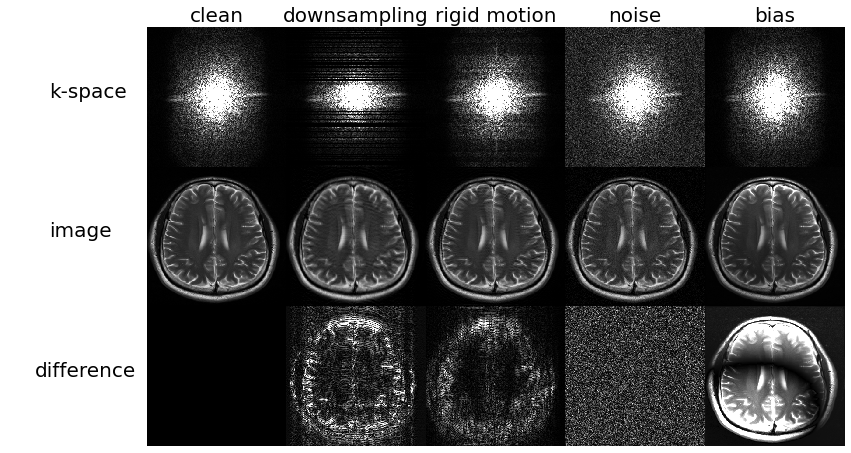

In [8]:
# brain
data_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\300008311232\808.dcm'
#data_path = r'C:\from SSD\fastMRI_brain_DICOM\100099070170\279.dcm'

data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)

img_noise = corrupt(image, "noise", 5, (0, 0), 0, 0, 0, 0) #SNR of 0 is worst noise
img_downsample = corrupt(image, "downsample", 0, (2, 0.16), 0, 0, 0, 0)
img_rigid_motion = corrupt(image, "rigid_motion", 0, (0, 0), 0.30, 0, 0, 0)
img_bias = corrupt(image, "bias", 0, (0, 0), 0, 0, 0, 1.00)

hr = image
lr_n = img_noise
lr_d = img_downsample
lr_m = img_rigid_motion
lr_b = img_bias

k_hr = np.abs(transform_image_to_kspace(hr))
k_lr_n = np.abs(transform_image_to_kspace(lr_n))
k_lr_d = np.abs(transform_image_to_kspace(lr_d))
k_lr_m = np.abs(transform_image_to_kspace(lr_m))
k_lr_b = np.abs(transform_image_to_kspace(lr_b))

k_hr = k_hr / np.max(np.abs(k_hr))
k_lr_n = k_lr_n / np.max(np.abs(k_lr_n))
k_lr_d = k_lr_d / np.max(np.abs(k_lr_d))
k_lr_m = k_lr_m / np.max(np.abs(k_lr_m))
k_lr_b = k_lr_b / np.max(np.abs(k_lr_b))

hr = (hr - np.mean(hr)) / np.std(hr)
lr_n = (lr_n - np.mean(lr_n)) / np.std(lr_n)
lr_d = (lr_d - np.mean(lr_d)) / np.std(lr_d)
lr_m = (lr_m - np.mean(lr_m)) / np.std(lr_m)
lr_b = (lr_b - np.mean(lr_b)) / np.std(lr_b)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

cols = ['clean', 'downsampling', 'rigid motion', 'noise', 'bias']
rows = ['k-space', 'image', 'difference']

fig = plt.figure(figsize=(15, 7.7))
ax = fig.add_subplot(3, 6, 1)
ax.text(0.3, 0.5, 'k-space', fontsize=20)
ax.axis('off')
ax = fig.add_subplot(3, 6, 2)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('clean', fontsize=20)
ax.axis('off')
ax = fig.add_subplot(3, 6, 3)
ax.imshow(k_lr_d, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('downsampling', fontsize=20)
ax.axis('off')
ax = fig.add_subplot(3, 6, 4)
ax.imshow(k_lr_m, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('rigid motion', fontsize=20)
ax.axis('off')
ax = fig.add_subplot(3, 6, 5)
ax.imshow(k_lr_n, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('noise', fontsize=20)
ax.axis('off')
ax = fig.add_subplot(3, 6, 6)
ax.imshow(k_lr_b, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('bias', fontsize=20)
ax.axis('off')

ax = fig.add_subplot(3, 6, 7)
ax.text(0.3, 0.5, 'image', fontsize=20)
ax.axis('off')
ax = fig.add_subplot(3, 6, 8)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(3, 6, 9)
ax.imshow(lr_d, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(3, 6, 10)
ax.imshow(lr_m, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(3, 6, 11)
ax.imshow(lr_n, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(3, 6, 12)
ax.imshow(lr_b, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')

ax = fig.add_subplot(3, 6, 13)
ax.text(0.2, 0.5, 'difference', fontsize=20)
ax.axis('off')
ax = fig.add_subplot(3, 6, 14)
ax.imshow(np.abs(hr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(3, 6, 15)
ax.imshow(np.abs(lr_d - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(3, 6, 16)
ax.imshow(np.abs(lr_m - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(3, 6, 17)
ax.imshow(np.abs(lr_n - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(3, 6, 18)
ax.imshow(np.abs(lr_b - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)

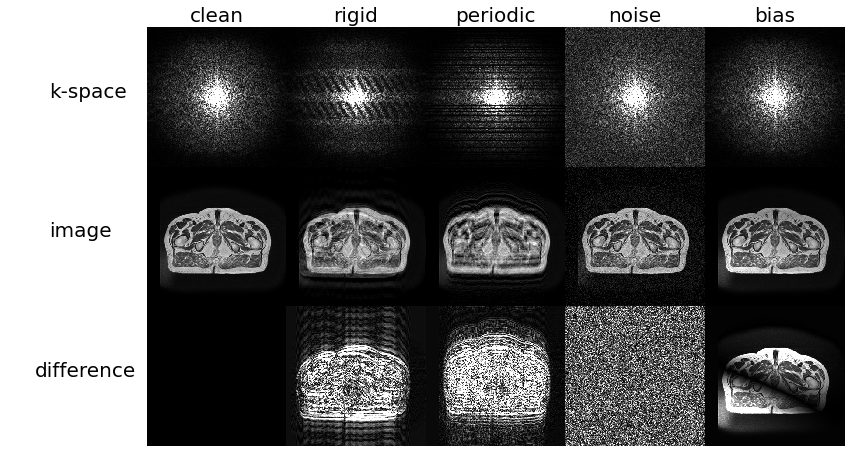

In [9]:
# pelvis

data_path = r"C:\Users\simon\anaconda3\envs\drs\drs\Data\Pelvis\Pelvis_2233,MP Pelvis_2233,MP\CT.2.25.168430369902691384448665480955143203741.dcm"
#data_path = r"D:\Pelvis_2.2\Pelvis_2001,MP Pelvis_2001,MP\CT.2.25.106642115696625184543345874653259618744.dcm"

data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)

img_noise = corrupt(image, "noise", 0, (0, 0), 0, 0, 0, 0) #SNR of 0 is worst noise
img_rigid_motion = corrupt(image, "rigid_motion", 0, (0, 0), 0.3, 0, 0, 0)
img_periodic_motion = corrupt(image, "periodic_motion", 0, (0, 0), 0, 20, np.pi/10, 0)
img_bias = corrupt(image, "bias", 0, (0, 0), 0, 0, 0, 1.00)

hr = image
lr_n = img_noise
lr_r = img_rigid_motion
lr_p = img_periodic_motion
lr_b = img_bias

k_hr = np.abs(transform_image_to_kspace(hr))
k_lr_n = np.abs(transform_image_to_kspace(lr_n))
k_lr_r = np.abs(transform_image_to_kspace(lr_r))
k_lr_p = np.abs(transform_image_to_kspace(lr_p))
k_lr_b = np.abs(transform_image_to_kspace(lr_b))

k_hr = k_hr / np.max(np.abs(k_hr))
k_lr_n = k_lr_n / np.max(np.abs(k_lr_n))
k_lr_r = k_lr_r / np.max(np.abs(k_lr_r))
k_lr_p = k_lr_p / np.max(np.abs(k_lr_p))
k_lr_b = k_lr_b / np.max(np.abs(k_lr_b))

hr = (hr - np.mean(hr)) / np.std(hr)
lr_n = (lr_n - np.mean(lr_n)) / np.std(lr_n)
lr_r = (lr_r - np.mean(lr_r)) / np.std(lr_r)
lr_p = (lr_p - np.mean(lr_p)) / np.std(lr_p)
lr_b = (lr_b - np.mean(lr_b)) / np.std(lr_b)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

fig = plt.figure(figsize=(15, 7.7))
ax = fig.add_subplot(3, 6, 1)
ax.text(0.3, 0.5, 'k-space', fontsize=20)
ax.axis('off')
ax = fig.add_subplot(3, 6, 2)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('clean', fontsize=20)
ax.axis('off')
ax = fig.add_subplot(3, 6, 3)
ax.imshow(k_lr_r, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('rigid', fontsize=20)
ax.axis('off')
ax = fig.add_subplot(3, 6, 4)
ax.imshow(k_lr_p, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('periodic', fontsize=20)
ax.axis('off')
ax = fig.add_subplot(3, 6, 5)
ax.imshow(k_lr_n, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('noise', fontsize=20)
ax.axis('off')
ax = fig.add_subplot(3, 6, 6)
ax.imshow(k_lr_b, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('bias', fontsize=20)
ax.axis('off')

ax = fig.add_subplot(3, 6, 7)
ax.text(0.3, 0.5, 'image', fontsize=20)
ax.axis('off')
ax = fig.add_subplot(3, 6, 8)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(3, 6, 9)
ax.imshow(lr_r, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(3, 6, 10)
ax.imshow(lr_p, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(3, 6, 11)
ax.imshow(lr_n, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(3, 6, 12)
ax.imshow(lr_b, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')

ax = fig.add_subplot(3, 6, 13)
ax.text(0.2, 0.5, 'difference', fontsize=20)
ax.axis('off')
ax = fig.add_subplot(3, 6, 14)
ax.imshow(np.abs(hr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(3, 6, 15)
ax.imshow(np.abs(lr_r - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(3, 6, 16)
ax.imshow(np.abs(lr_p - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(3, 6, 17)
ax.imshow(np.abs(lr_n - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(3, 6, 18)
ax.imshow(np.abs(lr_b - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
    
plt.subplots_adjust(wspace=0, hspace=0)

# Report

In [10]:
# corrupt function

def corrupt(image, case, factor, PE_direction, sampling):
    import random
    kspace = transform_image_to_kspace(image)
    
    if case == "noise":
        mean_signal = np.mean(np.abs(kspace))
        std_noise = mean_signal / 10**(signal_to_noise / 20)
        noise = np.random.normal(0, std_noise, size=np.shape(kspace)) + 1j*np.random.normal(0, std_noise, size=np.shape(kspace))
        kspace += noise
    
    elif case == "undersample":
        mask = cartesian_mask(factor, PE_direction, sampling)  
        kspace = np.where(mask, kspace, (0 + 0j))
        
    elif case == "rigid_motion":
        #random.choice(["LR", "AP"])
        kspace = rigid_motion(image, "AP", np.random.randint(1, 9), 3, 10, corrupt_pct_range)
        
    elif case == "periodic_motion":
        kspace = periodic_motion(kspace, delta)
            
    elif case == "bias":
        image = (image - np.min(image))/(np.max(image) - np.min(image))
        bias = GetFields(image, bias_rng)
        img = np.multiply(image, bias)
        kspace = transform_image_to_kspace(img)
      
    img = transform_kspace_to_image(kspace)
    img = (img - np.mean(img)) / np.std(img)
    return img

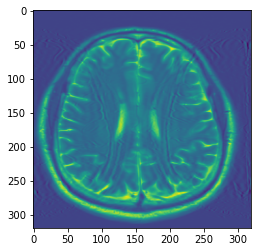

In [11]:
#data_path = r'C:\from SSD\fastMRI_brain_DICOM\100099070170\279.dcm'
data_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\300008311232\808.dcm'

data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)

img_2_LR = corrupt(image, "undersample", (2, 0.16), "LR", "uniform")

plt.imshow(img_2_LR)

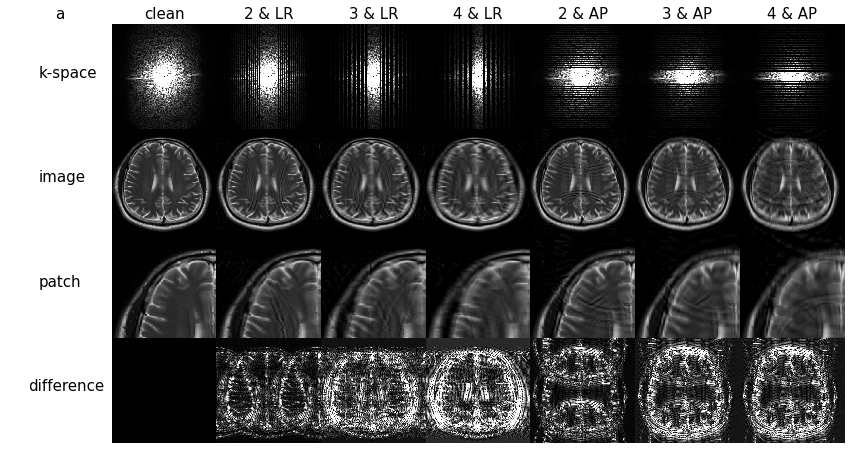

In [12]:
# uniform sampling
#data_path = r'C:\from SSD\fastMRI_brain_DICOM\100099070170\279.dcm'
data_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\300008311232\808.dcm'

data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)
hr = image

img_2_LR = corrupt(image, "undersample", (2, 0.16), "LR", "uniform")
img_3_LR = corrupt(image, "undersample", (3, 0.12), "LR", "uniform")
img_4_LR = corrupt(image, "undersample", (4, 0.08), "LR", "uniform")
img_2_AP = corrupt(image, "undersample", (2, 0.16), "AP", "uniform")
img_3_AP = corrupt(image, "undersample", (3, 0.12), "AP", "uniform")
img_4_AP = corrupt(image, "undersample", (4, 0.08), "AP", "uniform")

k_hr = np.abs(transform_image_to_kspace(hr))
k_2_LR = np.abs(transform_image_to_kspace(img_2_LR))
k_3_LR = np.abs(transform_image_to_kspace(img_3_LR))
k_4_LR = np.abs(transform_image_to_kspace(img_4_LR))
k_2_AP = np.abs(transform_image_to_kspace(img_2_AP))
k_3_AP = np.abs(transform_image_to_kspace(img_3_AP))
k_4_AP = np.abs(transform_image_to_kspace(img_4_AP))

k_hr = k_hr / np.max(np.abs(k_hr))
k_2_LR = k_2_LR / np.max(np.abs(k_2_LR))
k_3_LR = k_3_LR / np.max(np.abs(k_3_LR))
k_4_LR = k_4_LR / np.max(np.abs(k_4_LR))
k_2_AP = k_2_AP / np.max(np.abs(k_2_AP))
k_3_AP = k_3_AP / np.max(np.abs(k_3_AP))
k_4_AP = k_4_AP / np.max(np.abs(k_4_AP))

hr = (hr - np.mean(hr)) / np.std(hr)
img_2_LR = (img_2_LR - np.mean(img_2_LR)) / np.std(img_2_LR)
img_3_LR = (img_3_LR - np.mean(img_3_LR)) / np.std(img_3_LR)
img_4_LR = (img_4_LR - np.mean(img_4_LR)) / np.std(img_4_LR)
img_2_AP = (img_2_AP - np.mean(img_2_AP)) / np.std(img_2_AP)
img_3_AP = (img_3_AP - np.mean(img_3_AP)) / np.std(img_3_AP)
img_4_AP = (img_4_AP - np.mean(img_4_AP)) / np.std(img_4_AP)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

# k-space
fig = plt.figure(figsize=(15, 7.7))
ax = fig.add_subplot(4, 8, 1)
ax.text(0.3, 0.5, 'k-space', fontsize=15)
ax.set_title('a', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 2)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('clean', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 3)
ax.imshow(k_2_LR, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('2 & LR', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 4)
ax.imshow(k_3_LR, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('3 & LR', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 5)
ax.imshow(k_4_LR, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('4 & LR', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 6)
ax.imshow(k_2_AP, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('2 & AP', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 7)
ax.imshow(k_3_AP, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('3 & AP', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 8)
ax.imshow(k_4_AP, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('4 & AP', fontsize=15)
ax.axis('off')

# image
ax = fig.add_subplot(4, 8, 9)
ax.text(0.3, 0.5, 'image', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 10)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 11)
ax.imshow(img_2_LR, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 12)
ax.imshow(img_3_LR, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 13)
ax.imshow(img_4_LR, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 14)
ax.imshow(img_2_AP, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 15)
ax.imshow(img_3_AP, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 16)
ax.imshow(img_4_AP, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')

# image patch
ax = fig.add_subplot(4, 8, 17)
ax.text(0.3, 0.5, 'patch', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 18)
ax.imshow(hr[:160, :160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 19)
ax.imshow(img_2_LR[:160, :160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 20)
ax.imshow(img_3_LR[:160, :160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 21)
ax.imshow(img_4_LR[:160, :160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 22)
ax.imshow(img_2_AP[:160, :160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 23)
ax.imshow(img_3_AP[:160, :160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 24)
ax.imshow(img_4_AP[:160, :160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')

# difference
ax = fig.add_subplot(4, 8, 25)
ax.text(0.2, 0.5, 'difference', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 26)
ax.imshow(np.abs(hr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 27)
ax.imshow(np.abs(img_2_LR - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 28)
ax.imshow(np.abs(img_3_LR - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 29)
ax.imshow(np.abs(img_4_LR - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 30)
ax.imshow(np.abs(img_2_AP - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 31)
ax.imshow(np.abs(img_3_AP - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 32)
ax.imshow(np.abs(img_3_AP - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)

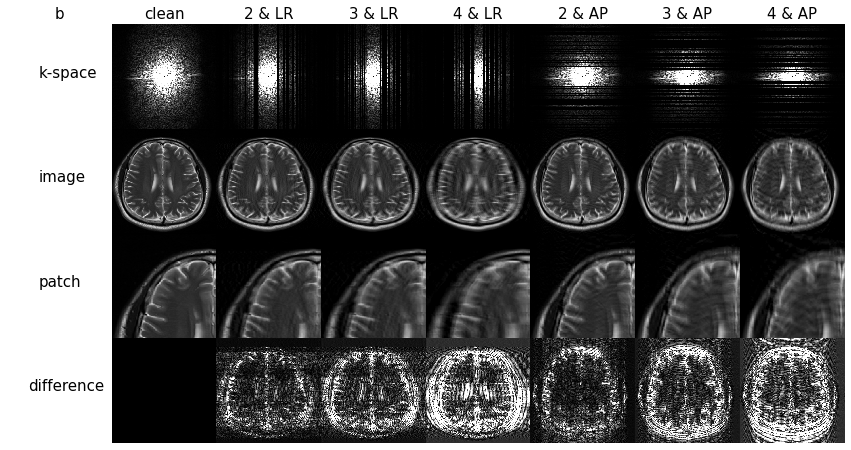

In [13]:
# random sampling
#data_path = r'C:\from SSD\fastMRI_brain_DICOM\100099070170\279.dcm'
data_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\300008311232\808.dcm'

data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)
hr = image

img_2_LR = corrupt(image, "undersample", (2, 0.16), "LR", "random")
img_3_LR = corrupt(image, "undersample", (3, 0.12), "LR", "random")
img_4_LR = corrupt(image, "undersample", (4, 0.08), "LR", "random")
img_2_AP = corrupt(image, "undersample", (2, 0.16), "AP", "random")
img_3_AP = corrupt(image, "undersample", (3, 0.12), "AP", "random")
img_4_AP = corrupt(image, "undersample", (4, 0.08), "AP", "random")

k_hr = np.abs(transform_image_to_kspace(hr))
k_2_LR = np.abs(transform_image_to_kspace(img_2_LR))
k_3_LR = np.abs(transform_image_to_kspace(img_3_LR))
k_4_LR = np.abs(transform_image_to_kspace(img_4_LR))
k_2_AP = np.abs(transform_image_to_kspace(img_2_AP))
k_3_AP = np.abs(transform_image_to_kspace(img_3_AP))
k_4_AP = np.abs(transform_image_to_kspace(img_4_AP))

k_hr = k_hr / np.max(np.abs(k_hr))
k_2_LR = k_2_LR / np.max(np.abs(k_2_LR))
k_3_LR = k_3_LR / np.max(np.abs(k_3_LR))
k_4_LR = k_4_LR / np.max(np.abs(k_4_LR))
k_2_AP = k_2_AP / np.max(np.abs(k_2_AP))
k_3_AP = k_3_AP / np.max(np.abs(k_3_AP))
k_4_AP = k_4_AP / np.max(np.abs(k_4_AP))

hr = (hr - np.mean(hr)) / np.std(hr)
img_2_LR = (img_2_LR - np.mean(img_2_LR)) / np.std(img_2_LR)
img_3_LR = (img_3_LR - np.mean(img_3_LR)) / np.std(img_3_LR)
img_4_LR = (img_4_LR - np.mean(img_4_LR)) / np.std(img_4_LR)
img_2_AP = (img_2_AP - np.mean(img_2_AP)) / np.std(img_2_AP)
img_3_AP = (img_3_AP - np.mean(img_3_AP)) / np.std(img_3_AP)
img_4_AP = (img_4_AP - np.mean(img_4_AP)) / np.std(img_4_AP)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

# k-space
fig = plt.figure(figsize=(15, 7.7))
ax = fig.add_subplot(4, 8, 1)
ax.text(0.3, 0.5, 'k-space', fontsize=15)
ax.set_title('b', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 2)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('clean', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 3)
ax.imshow(k_2_LR, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('2 & LR', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 4)
ax.imshow(k_3_LR, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('3 & LR', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 5)
ax.imshow(k_4_LR, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('4 & LR', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 6)
ax.imshow(k_2_AP, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('2 & AP', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 7)
ax.imshow(k_3_AP, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('3 & AP', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 8)
ax.imshow(k_4_AP, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('4 & AP', fontsize=15)
ax.axis('off')

# image
ax = fig.add_subplot(4, 8, 9)
ax.text(0.3, 0.5, 'image', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 10)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 11)
ax.imshow(img_2_LR, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 12)
ax.imshow(img_3_LR, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 13)
ax.imshow(img_4_LR, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 14)
ax.imshow(img_2_AP, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 15)
ax.imshow(img_3_AP, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 16)
ax.imshow(img_4_AP, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')

# image patch
ax = fig.add_subplot(4, 8, 17)
ax.text(0.3, 0.5, 'patch', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 18)
ax.imshow(hr[:160, :160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 19)
ax.imshow(img_2_LR[:160, :160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 20)
ax.imshow(img_3_LR[:160, :160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 21)
ax.imshow(img_4_LR[:160, :160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 22)
ax.imshow(img_2_AP[:160, :160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 23)
ax.imshow(img_3_AP[:160, :160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 24)
ax.imshow(img_4_AP[:160, :160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')

# difference
ax = fig.add_subplot(4, 8, 25)
ax.text(0.2, 0.5, 'difference', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 26)
ax.imshow(np.abs(hr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 27)
ax.imshow(np.abs(img_2_LR - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 28)
ax.imshow(np.abs(img_3_LR - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 29)
ax.imshow(np.abs(img_4_LR - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 30)
ax.imshow(np.abs(img_2_AP - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 31)
ax.imshow(np.abs(img_3_AP - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 32)
ax.imshow(np.abs(img_4_AP - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)

In [14]:
# corrupt function

def corrupt(image, case, PE_direction, corrupt_pct_range):
    import random
    kspace = transform_image_to_kspace(image)
    
    if case == "noise":
        mean_signal = np.mean(np.abs(kspace))
        std_noise = mean_signal / 10**(signal_to_noise / 20)
        noise = np.random.normal(0, std_noise, size=np.shape(kspace)) + 1j*np.random.normal(0, std_noise, size=np.shape(kspace))
        kspace += noise
    
    elif case == "undersample":
        mask = cartesian_mask(factor, PE_direction, sampling)  
        kspace = np.where(mask, kspace, (0 + 0j))
        
    elif case == "rigid_motion":
        #random.choice(["LR", "AP"])
        kspace = rigid_motion(image, PE_direction, np.random.randint(1, 9), 3, 10, corrupt_pct_range)
        
    elif case == "periodic_motion":
        kspace = periodic_motion(kspace, delta)
            
    elif case == "bias":
        image = (image - np.min(image))/(np.max(image) - np.min(image))
        bias = GetFields(image, bias_rng)
        img = np.multiply(image, bias)
        kspace = transform_image_to_kspace(img)
      
    img = transform_kspace_to_image(kspace)
    img = (img - np.mean(img)) / np.std(img)
    return img

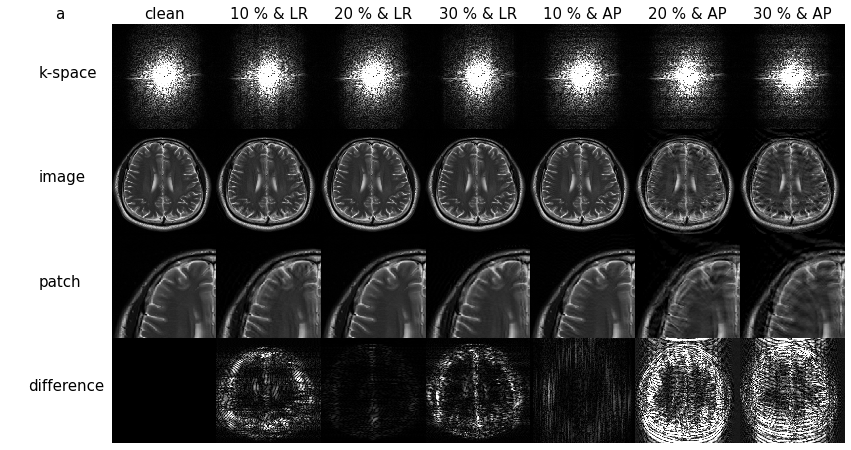

In [15]:
# rigid motion pelvis
#data_path = r'C:\from SSD\fastMRI_brain_DICOM\100099070170\279.dcm'
data_path = r'C:\Users\simon\anaconda3\envs\drs\drs\Data\fastMRI_brain_DICOM\300008311232\808.dcm'

data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)
hr = image

img_1_LR = corrupt(image, "rigid_motion", "LR", 0.1)
img_2_LR = corrupt(image, "rigid_motion", "LR", 0.2)
img_3_LR = corrupt(image, "rigid_motion", "LR", 0.3)
img_1_AP = corrupt(image, "rigid_motion", "AP", 0.1)
img_2_AP = corrupt(image, "rigid_motion", "AP", 0.2)
img_3_AP = corrupt(image, "rigid_motion", "AP", 0.3)

k_hr = np.abs(transform_image_to_kspace(hr))
k_1_LR = np.abs(transform_image_to_kspace(img_1_LR))
k_2_LR = np.abs(transform_image_to_kspace(img_2_LR))
k_3_LR = np.abs(transform_image_to_kspace(img_3_LR))
k_1_AP = np.abs(transform_image_to_kspace(img_1_AP))
k_2_AP = np.abs(transform_image_to_kspace(img_2_AP))
k_3_AP = np.abs(transform_image_to_kspace(img_3_AP))

k_hr = k_hr / np.max(np.abs(k_hr))
k_1_LR = k_1_LR / np.max(np.abs(k_1_LR))
k_2_LR = k_2_LR / np.max(np.abs(k_2_LR))
k_3_LR = k_3_LR / np.max(np.abs(k_3_LR))
k_1_AP = k_1_AP / np.max(np.abs(k_1_AP))
k_2_AP = k_2_AP / np.max(np.abs(k_2_AP))
k_3_AP = k_3_AP / np.max(np.abs(k_3_AP))

hr = (hr - np.mean(hr)) / np.std(hr)
img_1_LR = (img_1_LR - np.mean(img_1_LR)) / np.std(img_1_LR)
img_2_LR = (img_2_LR - np.mean(img_2_LR)) / np.std(img_2_LR)
img_3_LR = (img_3_LR - np.mean(img_3_LR)) / np.std(img_3_LR)
img_1_AP = (img_1_AP - np.mean(img_1_AP)) / np.std(img_1_AP)
img_2_AP = (img_2_AP - np.mean(img_2_AP)) / np.std(img_2_AP)
img_3_AP = (img_3_AP - np.mean(img_3_AP)) / np.std(img_3_AP)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

# k-space
fig = plt.figure(figsize=(15, 7.7))
ax = fig.add_subplot(4, 8, 1)
ax.text(0.3, 0.5, 'k-space', fontsize=15)
ax.set_title('a', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 2)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('clean', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 3)
ax.imshow(k_1_LR, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('10 % & LR', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 4)
ax.imshow(k_2_LR, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('20 % & LR', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 5)
ax.imshow(k_3_LR, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('30 % & LR', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 6)
ax.imshow(k_1_AP, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('10 % & AP', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 7)
ax.imshow(k_2_AP, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('20 % & AP', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 8)
ax.imshow(k_3_AP, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('30 % & AP', fontsize=15)
ax.axis('off')

# image
ax = fig.add_subplot(4, 8, 9)
ax.text(0.3, 0.5, 'image', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 10)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 11)
ax.imshow(img_1_LR, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 12)
ax.imshow(img_2_LR, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 13)
ax.imshow(img_3_LR, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 14)
ax.imshow(img_1_AP, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 15)
ax.imshow(img_2_AP, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 16)
ax.imshow(img_3_AP, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')

# image patch
ax = fig.add_subplot(4, 8, 17)
ax.text(0.3, 0.5, 'patch', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 18)
ax.imshow(hr[:160, :160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 19)
ax.imshow(img_1_LR[:160, :160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 20)
ax.imshow(img_2_LR[:160, :160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 21)
ax.imshow(img_3_LR[:160, :160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 22)
ax.imshow(img_1_AP[:160, :160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 23)
ax.imshow(img_2_AP[:160, :160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 24)
ax.imshow(img_3_AP[:160, :160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')

# difference
ax = fig.add_subplot(4, 8, 25)
ax.text(0.2, 0.5, 'difference', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 26)
ax.imshow(np.abs(hr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 27)
ax.imshow(np.abs(img_1_LR - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 28)
ax.imshow(np.abs(img_2_LR - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 29)
ax.imshow(np.abs(img_3_LR - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 30)
ax.imshow(np.abs(img_1_AP - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 31)
ax.imshow(np.abs(img_2_AP - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 32)
ax.imshow(np.abs(img_3_AP - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)

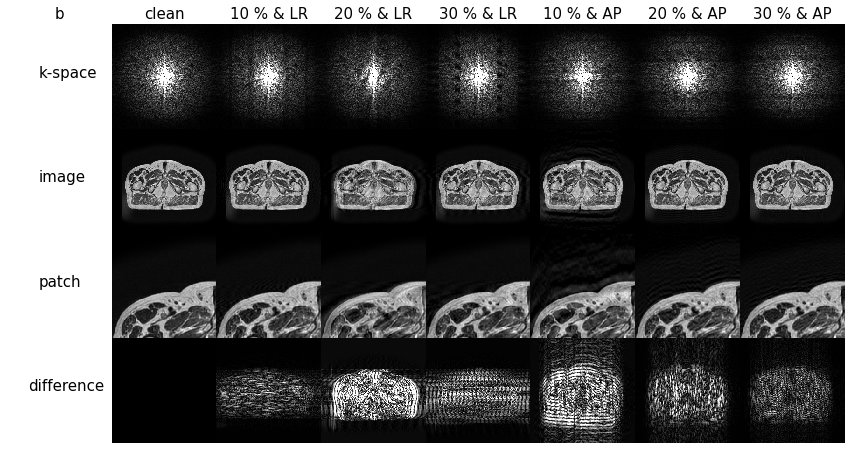

In [16]:
# rigid motion pelvis
data_path = r"C:\Users\simon\anaconda3\envs\drs\drs\Data\Pelvis\Pelvis_2233,MP Pelvis_2233,MP\CT.2.25.168430369902691384448665480955143203741.dcm"

data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)
hr = image

img_1_LR = corrupt(image, "rigid_motion", "LR", 0.1)
img_2_LR = corrupt(image, "rigid_motion", "LR", 0.2)
img_3_LR = corrupt(image, "rigid_motion", "LR", 0.3)
img_1_AP = corrupt(image, "rigid_motion", "AP", 0.1)
img_2_AP = corrupt(image, "rigid_motion", "AP", 0.2)
img_3_AP = corrupt(image, "rigid_motion", "AP", 0.3)

k_hr = np.abs(transform_image_to_kspace(hr))
k_1_LR = np.abs(transform_image_to_kspace(img_1_LR))
k_2_LR = np.abs(transform_image_to_kspace(img_2_LR))
k_3_LR = np.abs(transform_image_to_kspace(img_3_LR))
k_1_AP = np.abs(transform_image_to_kspace(img_1_AP))
k_2_AP = np.abs(transform_image_to_kspace(img_2_AP))
k_3_AP = np.abs(transform_image_to_kspace(img_3_AP))

k_hr = k_hr / np.max(np.abs(k_hr))
k_1_LR = k_1_LR / np.max(np.abs(k_1_LR))
k_2_LR = k_2_LR / np.max(np.abs(k_2_LR))
k_3_LR = k_3_LR / np.max(np.abs(k_3_LR))
k_1_AP = k_1_AP / np.max(np.abs(k_1_AP))
k_2_AP = k_2_AP / np.max(np.abs(k_2_AP))
k_3_AP = k_3_AP / np.max(np.abs(k_3_AP))

hr = (hr - np.mean(hr)) / np.std(hr)
img_1_LR = (img_1_LR - np.mean(img_1_LR)) / np.std(img_1_LR)
img_2_LR = (img_2_LR - np.mean(img_2_LR)) / np.std(img_2_LR)
img_3_LR = (img_3_LR - np.mean(img_3_LR)) / np.std(img_3_LR)
img_1_AP = (img_1_AP - np.mean(img_1_AP)) / np.std(img_1_AP)
img_2_AP = (img_2_AP - np.mean(img_2_AP)) / np.std(img_2_AP)
img_3_AP = (img_3_AP - np.mean(img_3_AP)) / np.std(img_3_AP)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

# k-space
fig = plt.figure(figsize=(15, 7.7))
ax = fig.add_subplot(4, 8, 1)
ax.text(0.3, 0.5, 'k-space', fontsize=15)
ax.set_title('b', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 2)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('clean', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 3)
ax.imshow(k_1_LR, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('10 % & LR', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 4)
ax.imshow(k_2_LR, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('20 % & LR', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 5)
ax.imshow(k_3_LR, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('30 % & LR', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 6)
ax.imshow(k_1_AP, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('10 % & AP', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 7)
ax.imshow(k_2_AP, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('20 % & AP', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 8)
ax.imshow(k_3_AP, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('30 % & AP', fontsize=15)
ax.axis('off')

# image
ax = fig.add_subplot(4, 8, 9)
ax.text(0.3, 0.5, 'image', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 10)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 11)
ax.imshow(img_1_LR, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 12)
ax.imshow(img_2_LR, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 13)
ax.imshow(img_3_LR, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 14)
ax.imshow(img_1_AP, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 15)
ax.imshow(img_2_AP, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 16)
ax.imshow(img_3_AP, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')

# image patch
ax = fig.add_subplot(4, 8, 17)
ax.text(0.3, 0.5, 'patch', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 18)
ax.imshow(hr[40:160, 40:160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 19)
ax.imshow(img_1_LR[40:160, 40:160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 20)
ax.imshow(img_2_LR[40:160, 40:160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 21)
ax.imshow(img_3_LR[40:160, 40:160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 22)
ax.imshow(img_1_AP[40:160, 40:160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 23)
ax.imshow(img_2_AP[40:160, 40:160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 24)
ax.imshow(img_3_AP[40:160, 40:160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')

# difference
ax = fig.add_subplot(4, 8, 25)
ax.text(0.2, 0.5, 'difference', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 26)
ax.imshow(np.abs(hr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 27)
ax.imshow(np.abs(img_1_LR - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 28)
ax.imshow(np.abs(img_2_LR - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 29)
ax.imshow(np.abs(img_3_LR - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 30)
ax.imshow(np.abs(img_1_AP - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 31)
ax.imshow(np.abs(img_2_AP - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 32)
ax.imshow(np.abs(img_3_AP - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)

In [17]:
# corrupt function

def corrupt(image, case, delta, ky0):
    import random
    kspace = transform_image_to_kspace(image)
    
    if case == "noise":
        mean_signal = np.mean(np.abs(kspace))
        std_noise = mean_signal / 10**(signal_to_noise / 20)
        noise = np.random.normal(0, std_noise, size=np.shape(kspace)) + 1j*np.random.normal(0, std_noise, size=np.shape(kspace))
        kspace += noise
    
    elif case == "undersample":
        mask = cartesian_mask(factor, PE_direction, sampling)  
        kspace = np.where(mask, kspace, (0 + 0j))
        
    elif case == "rigid_motion":
        #random.choice(["LR", "AP"])
        kspace = rigid_motion(image, PE_direction, np.random.randint(1, 9), 3, 10, corrupt_pct_range)
        
    elif case == "periodic_motion":
        kspace = periodic_motion(kspace, delta, ky0)
            
    elif case == "bias":
        image = (image - np.min(image))/(np.max(image) - np.min(image))
        bias = GetFields(image, bias_rng)
        img = np.multiply(image, bias)
        kspace = transform_image_to_kspace(img)
      
    img = transform_kspace_to_image(kspace)
    img = (img - np.mean(img)) / np.std(img)
    return img

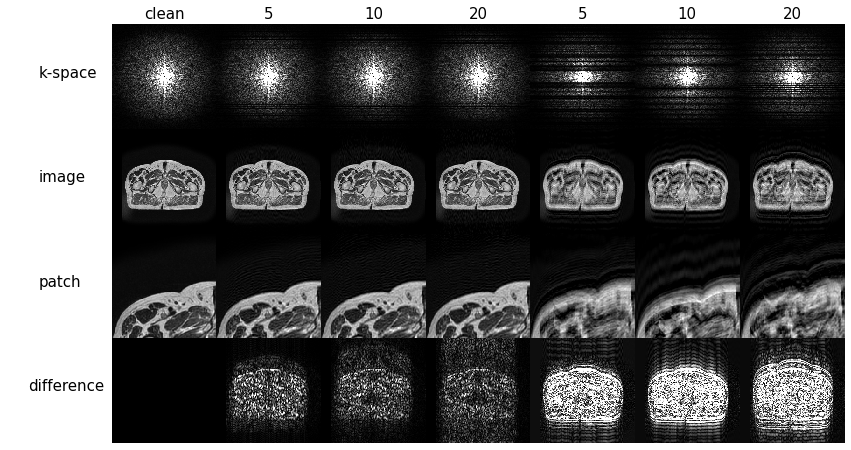

In [19]:
# periodic motion

data_path = r"C:\Users\simon\anaconda3\envs\drs\drs\Data\Pelvis\Pelvis_2233,MP Pelvis_2233,MP\CT.2.25.168430369902691384448665480955143203741.dcm"

data = pydicom.dcmread(data_path)

image = data.pixel_array
if (np.shape(image) != (320, 320)):
    image = cv2.resize(image, (320, 320))

image = (image - np.mean(image)) / np.std(image)
hr = image

img_5_2 = corrupt(image, "periodic_motion", 5, np.pi/2)
img_10_2 = corrupt(image, "periodic_motion", 10, np.pi/2)
img_20_2 = corrupt(image, "periodic_motion", 20, np.pi/2)
img_5_10 = corrupt(image, "periodic_motion", 5, np.pi/10)
img_10_10 = corrupt(image, "periodic_motion", 10, np.pi/10)
img_20_10 = corrupt(image, "periodic_motion", 20, np.pi/10)

k_hr = np.abs(transform_image_to_kspace(hr))
k_5_2 = np.abs(transform_image_to_kspace(img_5_2))
k_10_2 = np.abs(transform_image_to_kspace(img_10_2))
k_20_2 = np.abs(transform_image_to_kspace(img_20_2))
k_5_10 = np.abs(transform_image_to_kspace(img_5_10))
k_10_10 = np.abs(transform_image_to_kspace(img_10_10))
k_20_10 = np.abs(transform_image_to_kspace(img_20_10))

k_hr = k_hr / np.max(np.abs(k_hr))
k_5_2 = k_5_2 / np.max(np.abs(k_5_2))
k_10_2 = k_10_2 / np.max(np.abs(k_10_2))
k_20_2 = k_20_2 / np.max(np.abs(k_20_2))
k_5_10 = k_5_10 / np.max(np.abs(k_5_10))
k_10_10 = k_10_10 / np.max(np.abs(k_10_10))
k_20_10 = k_20_10 / np.max(np.abs(k_20_10))

hr = (hr - np.mean(hr)) / np.std(hr)
img_5_2 = (img_5_2 - np.mean(img_5_2)) / np.std(img_5_2)
img_10_2 = (img_10_2 - np.mean(img_10_2)) / np.std(img_10_2)
img_20_2 = (img_20_2 - np.mean(img_20_2)) / np.std(img_20_2)
img_5_10 = (img_5_10 - np.mean(img_5_10)) / np.std(img_5_10)
img_10_10 = (img_10_10 - np.mean(img_10_10)) / np.std(img_10_10)
img_20_10 = (img_20_10 - np.mean(img_20_10)) / np.std(img_20_10)

vmx = np.max(hr)
vmn = np.min(hr)
dmx = 0.5
kmx = 0.01

# k-space
fig = plt.figure(figsize=(15, 7.7))
ax = fig.add_subplot(4, 8, 1)
ax.text(0.3, 0.5, 'k-space', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 2)
ax.imshow(k_hr, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('clean', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 3)
ax.imshow(k_5_2, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('5', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 4)
ax.imshow(k_10_2, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('10', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 5)
ax.imshow(k_20_2, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('20', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 6)
ax.imshow(k_5_10, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('5', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 7)
ax.imshow(k_10_10, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('10', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 8)
ax.imshow(k_20_10, interpolation='none', cmap='gist_gray', vmin=0, vmax=kmx)
ax.set_title('20', fontsize=15)
ax.axis('off')

# image
ax = fig.add_subplot(4, 8, 9)
ax.text(0.3, 0.5, 'image', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 10)
ax.imshow(hr, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 11)
ax.imshow(img_5_2, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 12)
ax.imshow(img_10_2, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 13)
ax.imshow(img_20_2, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 14)
ax.imshow(img_5_10, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 15)
ax.imshow(img_10_10, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 16)
ax.imshow(img_20_10, interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')

# image patch
ax = fig.add_subplot(4, 8, 17)
ax.text(0.3, 0.5, 'patch', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 18)
ax.imshow(hr[40:160, 40:160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 19)
ax.imshow(img_5_2[40:160, 40:160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 20)
ax.imshow(img_10_2[40:160, 40:160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 21)
ax.imshow(img_20_2[40:160, 40:160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 22)
ax.imshow(img_5_10[40:160, 40:160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 23)
ax.imshow(img_10_10[40:160, 40:160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 24)
ax.imshow(img_20_10[40:160, 40:160], interpolation='none', cmap='gist_gray', vmin=vmn, vmax=vmx)
ax.axis('off')

# difference
ax = fig.add_subplot(4, 8, 25)
ax.text(0.2, 0.5, 'difference', fontsize=15)
ax.axis('off')
ax = fig.add_subplot(4, 8, 26)
ax.imshow(np.abs(hr - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 27)
ax.imshow(np.abs(img_5_2 - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 28)
ax.imshow(np.abs(img_10_2 - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 29)
ax.imshow(np.abs(img_20_2 - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 30)
ax.imshow(np.abs(img_5_10 - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 31)
ax.imshow(np.abs(img_10_10 - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')
ax = fig.add_subplot(4, 8, 32)
ax.imshow(np.abs(img_20_10 - hr), interpolation='none', cmap='gist_gray', vmin=0, vmax=dmx)
ax.axis('off')

plt.subplots_adjust(wspace=0, hspace=0)